<a href="https://colab.research.google.com/github/anamilanezi/google-data-analytics/blob/main/Sample_LatLong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1A6Ozzcfx-EqYeK5uwMx7-cTyyUMXIy0P)

<p align="right">
Photo by <a href="https://unsplash.com/@autumnstudio?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Autumn Studio</a> on <a href="https://unsplash.com/s/photos/bike-share?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a></p>
  

# **`CYCLISTIC BIKE SHARE`**


# Importing dataset

The data is clean and prepared to analysis, but some new manipulation was also performed here since I used the latitude and longitude values to calculate distance. The cleaning process is documented [here](https://www.kaggle.com/code/anamilanezi/google-capstone-project-cyclistic-bike-share). The clean dataframe uses only rides shorter than 240 minutes (4 hours).

The following libraries were used on this study:
* [Pandas](https://pandas.pydata.org/) for data cleaning, manipulation, organization, statistics and exploratory analysis
* [Seaborn](https://seaborn.pydata.org/) and [Matplotlib](https://matplotlib.org/) for data visuals 
* [Datetime](https://docs.python.org/3/library/datetime.html) for dates manipulation
* [Calendar](https://docs.python.org/3/library/calendar.html) to create month and week days dictionaries
* [h3](https://pypi.org/project/h3/) to calculate distance between coordinates
* [Shapely](https://pypi.org/project/Shapely/) to create point objects  
* [GeoPandas](https://geopandas.org/) to create geodataframes and plot maps 

<p align="justify">All data used in the study are made available by Lyft Bikes and Scooters, LLC which operates the City of Chicago’s. As part of a commitment with the City of Chicago to support bicycle as an alternative tranportation option, the service provides system data available to the public, subject to the terms and conditions of <a href="https://ride.divvybikes.com/data-license-agreement" target="_blank">this License Agreement.</a></p>

<p align="justify">The dataset doesn't provide personal and private information about the users, it's anonymized, comprehensive and represents current data making it a reliable and unbiased source.<p align="justify">

In [1]:
!pip install h3
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import h3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import calendar
import geopandas as gpd
from shapely.geometry import Point, Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


%matplotlib inline

In [3]:
kaggle = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    path = '../input/google-bike-share/clean_df.csv'
    kaggle = True
else:
    path = '/content/drive/MyDrive/Colab Notebooks/Google Capstone Project/data/clean_data/240/clean_df.csv'
finally:
    df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 🎨 Defining color palettes

In [40]:
def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

In [220]:
# Color palettes
my_palette = ['#3c9ab2', '#56a6ba', '#71b3c2', '#88b774', '#d1c74c', '#e8c520', '#e4b80d', '#e29e00', '#ea5c00', '#f22300']

cmap = ListedColormap(my_palette)
cmap_members = ListedColormap(['#d1c74c', '#88b774', '#71b3c2', '#56a6ba', '#3c9ab2'])
cmap_casual = ListedColormap(['#e8c520', '#e4b80d', '#e29e00', '#ea5c00', '#f22300'])

colors_member_casual = {"Member": '#88b774', "Casual": '#ea5c00' }
colors_day_of_week = {'Monday': '#3c9ab2', 'Tuesday': '#71b3c2', 'Wednesday': '#88b774', 'Thursday': '#ffde45', 'Friday': '#e4b80d', 'Saturday': '#ea5c00', 'Sunday': '#f22300'}


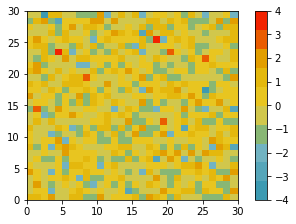

In [44]:
plot_examples([cmap])

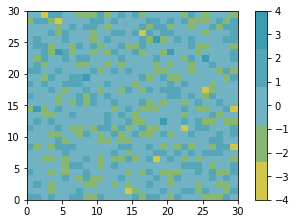

In [221]:
plot_examples([cmap_members])

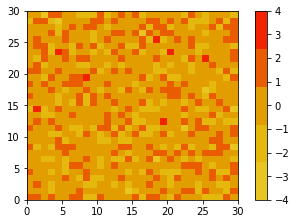

In [43]:
plot_examples([cmap_casual])

### 📅 Creating dates dictionaries

In [5]:
# Create a list with months order from July 2021 - June 2022:
months_order = [7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6]

# Create a dictionary for months:
month_names = {(i): name for i, name in enumerate(calendar.month_name) if i != 0}
print(month_names)

# Creat a dictionary for week days
days = {name: i + 1 for i, name in enumerate(calendar.day_name)}
print(days)

# Saving days order 
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

{1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
{'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}


## More cleaning and processing

In [6]:
# This summary shows inconsistent lat and long points outside Chicago area (max column)
df[['start_lat', 'start_lng', 'end_lat', 'end_lng']].describe().T

,count,mean,std,min,25%,50%,75%,max
start_lat,5883249.0,41.900612,0.047146,41.64,41.881032,41.898990,41.929540,45.635034
start_lng,5883249.0,-87.647190,0.030745,-87.84,-87.661501,-87.643241,-87.628361,-73.796477
end_lat,5883249.0,41.900844,0.047254,41.39,41.881034,41.899930,41.929546,42.168116
end_lng,5883249.0,-87.647369,0.030376,-88.97,-87.661535,-87.643353,-87.628579,-87.490000


In [7]:
# Removing values outside Chicago
df = df.query('start_lat < 42.2')

In [8]:
# Creating a column joining lng x lat (order used on plots)
df['start_station'] = [(xy) for xy in zip(df['start_lng'], df['start_lat'])]
df['end_station'] = [(xy) for xy in zip(df['end_lng'], df['end_lat'])]

In [9]:
# Calculating distance using h3
df['distance'] = df.apply(lambda row: h3.point_dist((row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng']), unit='km'), axis=1)

In [10]:
# Deleting redundant columns
df = df.drop(['start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1)

In [11]:
# Summary of distance and ride length minutes
df[['distance', 'ride_length_minutes']].describe().T

,count,mean,std,min,25%,50%,75%,max
distance,5883248.0,2.167700,1.964664,0.00,0.891286,1.608377,2.841254,114.383699
ride_length_minutes,5883248.0,16.918476,19.737231,0.02,6.270000,11.130000,20.100000,239.970000


By selecting only the rides with longer distances, we can see that there is one single value that is highly unusual in our dataset, so I decided to remove it.

In [12]:
df.query('distance > 20')[['distance', 'ride_length', 'start_station', 'end_station']].sort_values(by=['distance'], ascending=False).head(5)

,distance,ride_length,start_station,end_station
3136340,114.383699,0 days 00:55:04,"(-87.79, 41.92)","(-88.97, 41.39)"
4825593,42.272154,0 days 02:54:16,"(-87.62958416666666, 41.878810666666666)","(-88.14, 41.87)"
33715,32.210757,0 days 02:26:08,"(-87.66036516666667, 41.994727)","(-87.65713833333334, 41.705059)"
1075893,31.906514,0 days 01:56:42,"(-87.534814, 41.712749)","(-87.660274, 41.984045)"
1729886,31.008509,0 days 02:07:31,"(-87.66033433333334, 41.98406833333333)","(-87.54, 41.72)"


In [13]:
# New clean dataset
df = df.query('distance < 43')

In [15]:
# Turning str to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['started_at'] = pd.to_datetime(df['started_at'], format='%Y-%m-%d %H:%M:%S')
df['ended_at'] = pd.to_datetime(df['ended_at'], format='%Y-%m-%d %H:%M:%S')

df['time_start'] = df['started_at'].apply(lambda x: (x.time()))
df['time_end'] = df['ended_at'].apply(lambda x: (x.time()))


In [19]:
df['time_start'] = df['started_at'].apply(lambda x: (x.time()))
df['time_end'] = df['ended_at'].apply(lambda x: (x.time()))

In [21]:
# Deleting full date and categorical date related columns
df = df.drop(['ride_id', 'started_at',	'ended_at',	'day_of_week', 'month', 'ride_length'], axis=1)

In [22]:
df.head(5)

,rideable_type,member_casual,int_day_of_week,int_month,date,hour,ride_length_minutes,start_station,end_station,distance,time_start,time_end
0,electric_bike,Member,4,7,2021-07-01,0,4.48,"(-87.64, 41.84)","(-87.62586283333333, 41.834804166666665)",1.305942,00:00:22,00:04:51
1,classic_bike,Casual,4,7,2021-07-01,0,46.47,"(-87.65222, 41.91844)","(-87.658617, 41.932225)",1.621614,00:00:30,00:46:58
2,docked_bike,Casual,4,7,2021-07-01,0,9.72,"(-87.667855, 41.973348)","(-87.660141, 41.989743)",1.931334,00:00:42,00:10:25
3,classic_bike,Casual,4,7,2021-07-01,0,27.40,"(-87.624117, 41.886024)","(-87.62603, 41.886875)",0.184479,00:00:47,00:28:11
4,classic_bike,Casual,4,7,2021-07-01,0,15.83,"(-87.62603, 41.886875)","(-87.634656, 41.912133)",2.897883,00:00:53,00:16:43


In [23]:
# List of dataframes separeted by month
months = [df.query(f'int_month == {i}') for i in range(1, 13)]

# Taking a samples

## Creating a sample from dataset using calculated sample size

6585 or more measurements/surveys are needed to have a confidence level of 99.9% that the real value is within ±2% of the measured/surveyed value. Comparing statistical summary from whole dataset and sample shows the similar results

In [24]:
sample_df = df.sample(n=6758)

In [26]:
sample_df = sample_df.sort_values(by=['date', 'time_start'])

In [27]:
sample_df.describe().T

,count,mean,std,min,25%,50%,75%,max
int_day_of_week,6758.0,4.140574,1.984044,1.00,2.000000,4.000000,6.000000,7.000000
int_month,6758.0,7.209529,2.531299,1.00,5.000000,7.000000,9.000000,12.000000
hour,6758.0,14.386061,4.996784,0.00,11.000000,15.000000,18.000000,23.000000
ride_length_minutes,6758.0,17.129278,20.112232,0.02,6.272500,11.225000,20.292500,229.430000
distance,6758.0,2.163283,1.991080,0.00,0.880235,1.624831,2.859511,26.045463


In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
int_day_of_week,5883247.0,4.113577,1.991628,1.00,2.000000,4.000000,6.00000,7.000000
int_month,5883247.0,7.237199,2.569782,1.00,5.000000,7.000000,9.00000,12.000000
hour,5883247.0,14.208999,5.047652,0.00,11.000000,15.000000,18.00000,23.000000
ride_length_minutes,5883247.0,16.918470,19.737227,0.02,6.270000,11.130000,20.10000,239.970000
distance,5883247.0,2.167681,1.964119,0.00,0.891285,1.608377,2.84125,42.272154


## Creating random samples by month  based on calculated sample size:

I created a list of the minimun number of measurements for each month that are needed to show a confidence level of 99.9% that the real value is within ±2% of the measured values to create another sample with more data. This is because some months like January and February are highly different from others like June and July.


In [39]:
total = []
for i in range(1,13):
  month = month_names[i]
  num_rows = df.query(f'int_month == {i}')['ride_id'].count()
  total.append(num_rows)
  print(f"{month}: {num_rows}")

January: 103463
February: 115357
March: 283313
April: 370406
May: 633041
June: 766841
July: 819392
August: 801754
September: 753834
October: 629467
November: 359261
December: 247118


In [29]:
sample_size = [6350, 6391, 6608, 6644, 6694, 6706, 6710, 6709, 6705, 6694, 6641, 6585]
months = [df.query(f'int_month == {i}').sample(n=sample_size[i-1]) for i in range(1, 13)]

In [30]:
sample_month_df = pd.concat(months, ignore_index=True)

In [32]:
sample_month_df.describe().T

,count,mean,std,min,25%,50%,75%,max
int_day_of_week,79437.0,4.027632,1.988671,1.00,2.000000,4.000000,6.000000,7.000000
int_month,79437.0,6.536450,3.430754,1.00,4.000000,7.000000,10.000000,12.000000
hour,79437.0,14.073115,4.980459,0.00,11.000000,15.000000,18.000000,23.000000
ride_length_minutes,79437.0,15.545833,18.437470,0.02,5.780000,10.220000,18.380000,235.830000
distance,79437.0,2.084044,1.914834,0.00,0.854955,1.522516,2.718548,29.734041


In [31]:
sample_month_df = sample_month_df.sort_values(by=['date', 'time_start'])

# Plotting Ride Length x Distance

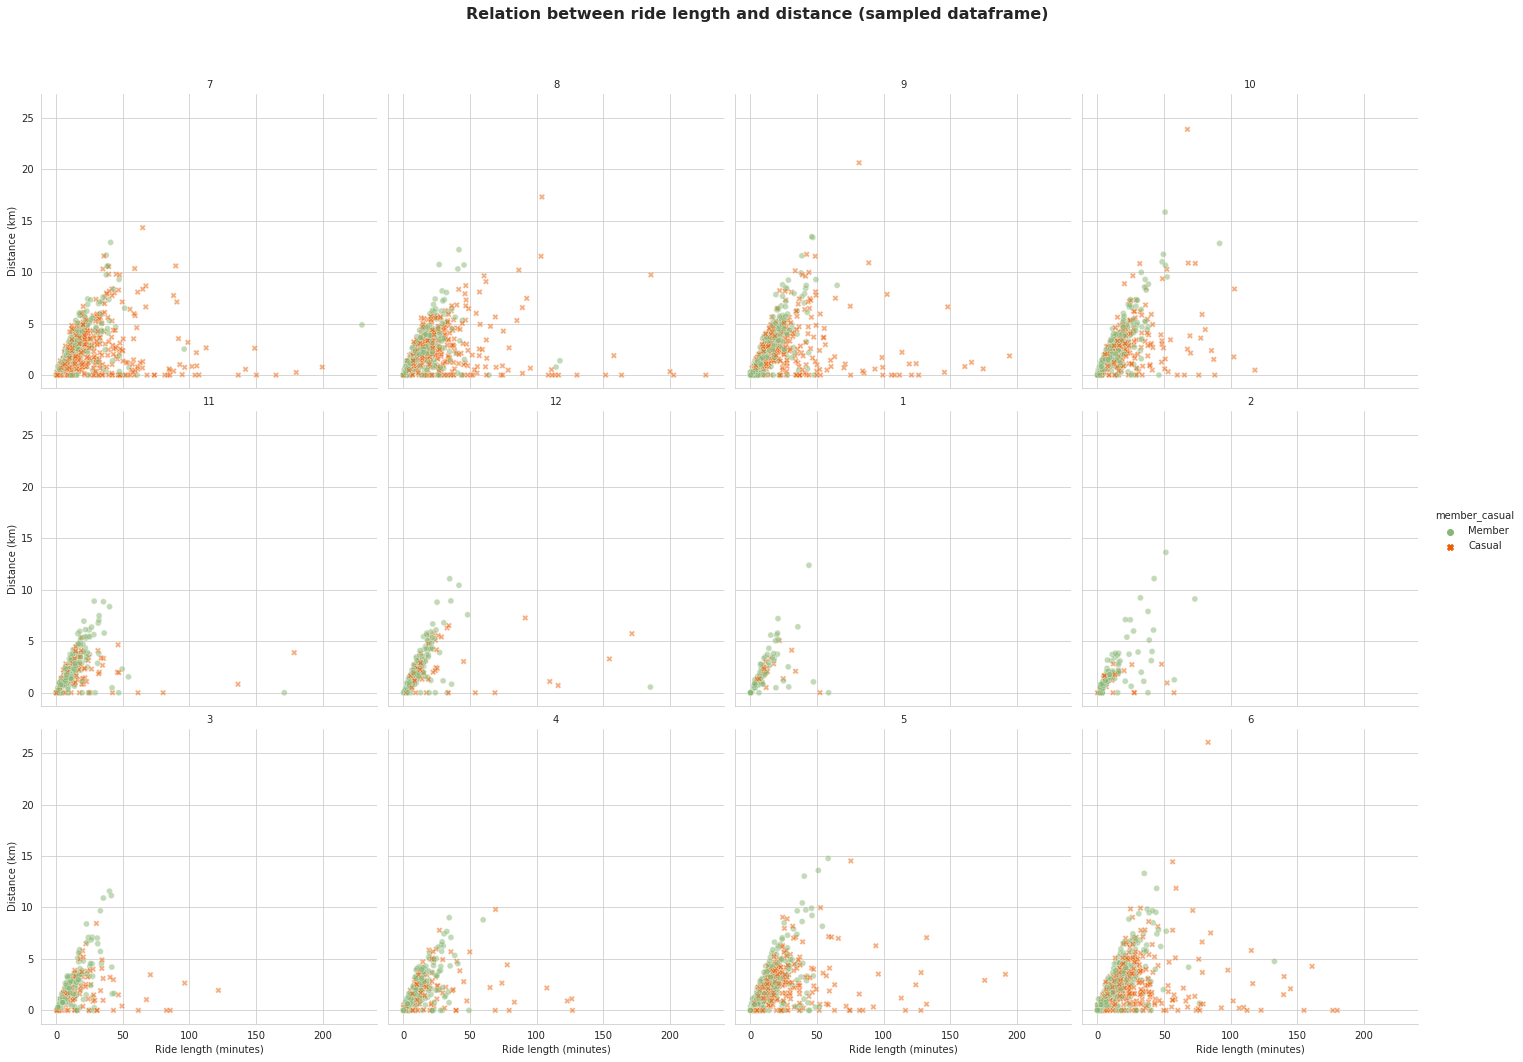

In [35]:
with sns.axes_style('whitegrid'):
  f1 = sns.relplot(
  data=sample_df,
  x="ride_length_minutes", 
  y="distance", 
  hue="member_casual",
  style="member_casual",
  col="int_month", 
  col_order=months_order,
  col_wrap=4, 
  alpha=0.5, 
  palette=colors_member_casual)
  f1.set(ylabel="Distance (km)", xlabel="Ride length (minutes)")
  f1.fig.subplots_adjust(top=.9)
  f1.set_titles(col_template="{col_name}")
  f1.fig.suptitle('Relation between ride length and distance (sampled dataframe)', fontsize=16, fontweight="bold")

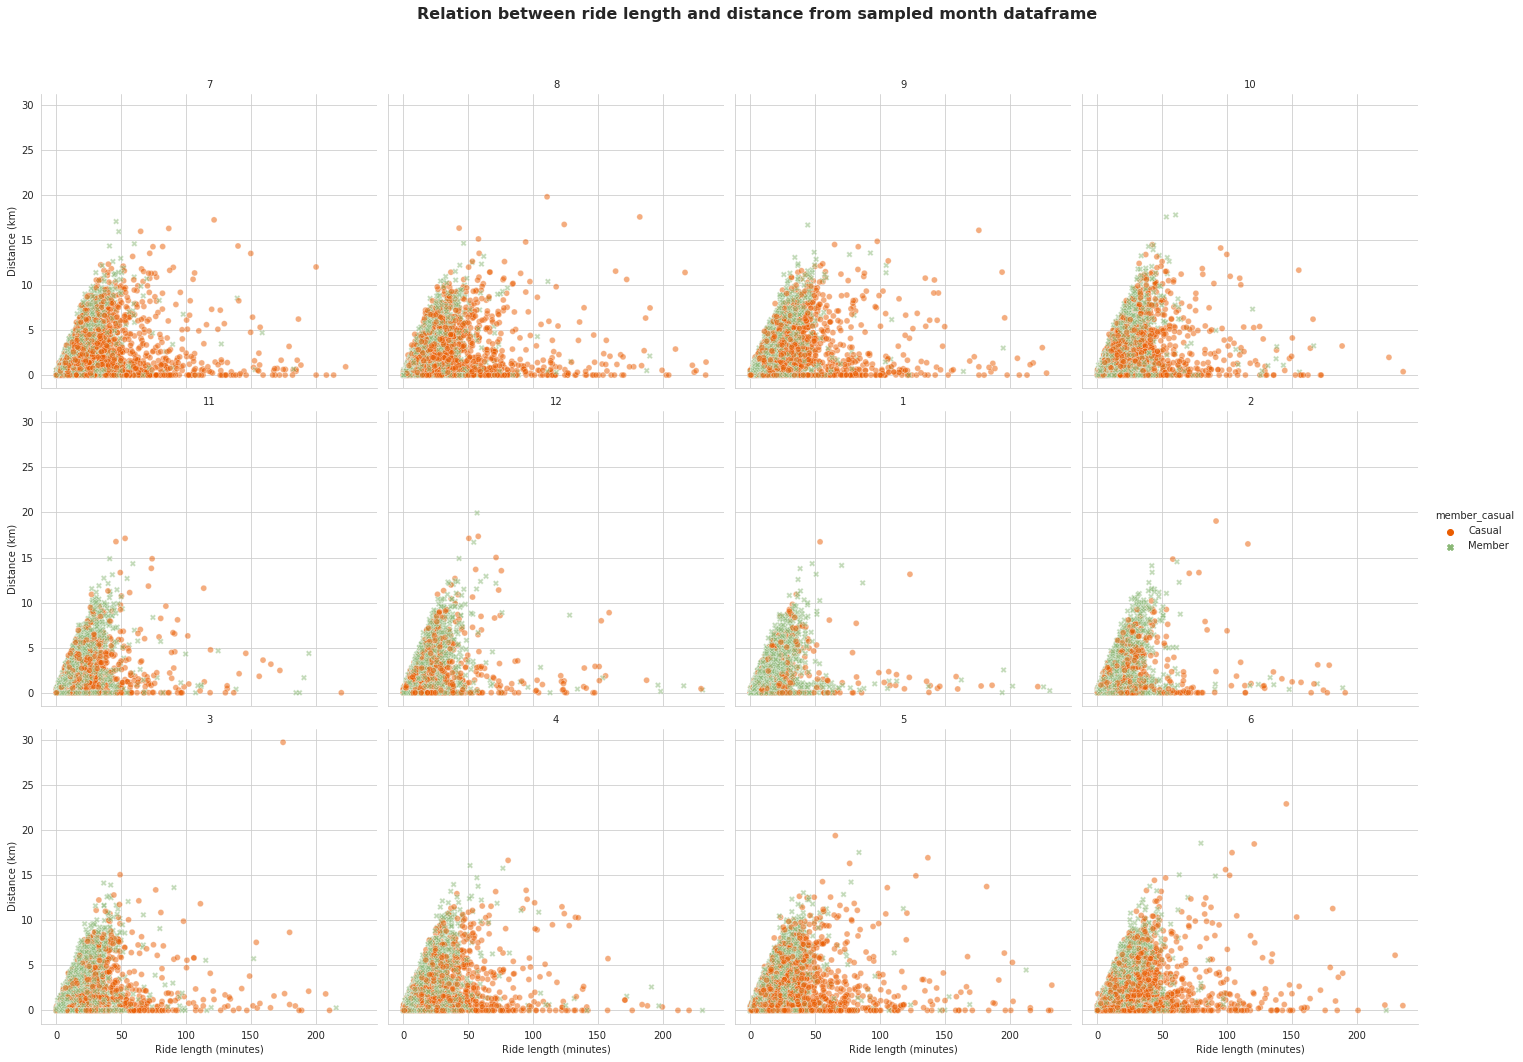

In [36]:
with sns.axes_style('whitegrid'):
  f1 = sns.relplot(
  data=sample_month_df,
  x="ride_length_minutes", 
  y="distance", 
  hue="member_casual",
  style="member_casual",
  col="int_month", 
  col_order=months_order,
  col_wrap=4, 
  alpha=0.5, 
  palette=colors_member_casual)
  f1.set(ylabel="Distance (km)", xlabel="Ride length (minutes)")
  f1.fig.subplots_adjust(top=.9)
  f1.set_titles(col_template="{col_name}")
  f1.fig.suptitle('Relation between ride length and distance from sampled month dataframe', fontsize=16, fontweight="bold")

# Grouping data by **Station**

## All costumers

In [37]:
# Grouping Lat x Long points to see most used stations

grouped_stations = df[['start_station', 'end_station', 'ride_length_minutes', 'distance']].groupby(['start_station', 'end_station'], as_index=False).agg({'ride_length_minutes': ['count', 'mean', 'median'], 'distance': ['mean', 'median']})


In [38]:
grouped_stations = grouped_stations.sort_values(by=('ride_length_minutes', 'count'), ascending=False)

In [39]:
grouped_stations.head()

start_station              end_station ride_length_minutes  \
                                                                        count   
1934132           (-87.6, 41.79)           (-87.6, 41.79)               21355   
1891187  (-87.612043, 41.892278)  (-87.612043, 41.892278)               10686   
1857812  (-87.616743, 41.880958)  (-87.616743, 41.880958)                6283   
1959680           (-87.59, 41.8)           (-87.59, 41.8)                6262   
1935142           (-87.6, 41.79)           (-87.59, 41.8)                5908   

                            distance            
              mean  median      mean    median  
1934132   4.308348   3.250  0.000000  0.000000  
1891187  42.056553  32.675  0.000000  0.000000  
1857812  37.174689  29.650  0.000000  0.000000  
1959680  11.578390   3.880  0.000000  0.000000  
1935142   8.314897   7.070  1.386964  1.386964

In [45]:
# Flatten multi index columns
grouped_stations.columns = ['_'.join(col) for col in grouped_stations.columns.values]

In [46]:
grouped_stations.columns = ['start_lng_lat', 'end_lng_lat', 'count', 'ride_length_mean', 'ride_length_median', 'distance_mean', 'distance_median']

In [48]:
grouped_stations.head(5)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
1934132,"(-87.6, 41.79)","(-87.6, 41.79)",21355,4.308348,3.250,0.000000,0.000000
1891187,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",10686,42.056553,32.675,0.000000,0.000000
1857812,"(-87.616743, 41.880958)","(-87.616743, 41.880958)",6283,37.174689,29.650,0.000000,0.000000
1959680,"(-87.59, 41.8)","(-87.59, 41.8)",6262,11.578390,3.880,0.000000,0.000000
1935142,"(-87.6, 41.79)","(-87.59, 41.8)",5908,8.314897,7.070,1.386964,1.386964


## Casual Users

In [49]:
# Grouping Lat x Long points to see most used stations

grouped_casual_station = df.query('member_casual == "Casual"')[['start_station', 'end_station', 'ride_length_minutes', 'distance']].groupby(['start_station', 'end_station'], as_index=False).agg({'ride_length_minutes': ['count', 'mean', 'median'], 'distance': ['mean', 'median']})

In [50]:
grouped_casual_station = grouped_casual_station.sort_values(by=('ride_length_minutes', 'count'), ascending=False)

In [51]:
# Flatten multi index columns
grouped_casual_station.columns = [''.join(col) for col in grouped_casual_station.columns.values]

In [52]:
grouped_casual_station.columns = ['start_lng_lat', 'end_lng_lat', 'count', 'ride_length_mean', 'ride_length_median', 'distance_mean', 'distance_median']

In [54]:
grouped_casual_station.head(5)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
916500,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",9494,44.926034,35.325,0.000000,0.000000
892359,"(-87.616743, 41.880958)","(-87.616743, 41.880958)",5631,39.168450,30.780,0.000000,0.000000
892369,"(-87.616743, 41.880958)","(-87.612043, 41.892278)",4761,28.409149,19.970,1.317487,1.317487
817018,"(-87.62377664, 41.90096039)","(-87.62377664, 41.90096039)",2820,45.351926,40.680,0.000000,0.000000
916490,"(-87.612043, 41.892278)","(-87.616743, 41.880958)",2588,29.991596,17.475,1.317487,1.317487


## Grouping members


In [56]:
# Grouping Lat x Long points to see most used stations

grouped_member_station = df.query('member_casual == "Member"')[['start_station', 'end_station', 'ride_length_minutes', 'distance']].groupby(['start_station', 'end_station'], as_index=False).agg({'ride_length_minutes': ['count', 'mean', 'median'], 'distance': ['mean', 'median']})

In [57]:
grouped_member_station = grouped_member_station.sort_values(by=('ride_length_minutes', 'count'), ascending=False)

In [58]:
# Flatten multi index columns
grouped_member_station.columns = [''.join(col) for col in grouped_member_station.columns.values]

In [59]:
grouped_member_station.columns = ['start_lng_lat', 'end_lng_lat', 'count', 'ride_length_mean', 'ride_length_median', 'distance_mean', 'distance_median']

In [61]:
grouped_member_station.head(5)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
1103204,"(-87.6, 41.79)","(-87.6, 41.79)",19460,4.100821,3.20,0.000000,0.000000
1120495,"(-87.59, 41.8)","(-87.59, 41.8)",5324,11.516414,3.78,0.000000,0.000000
1096565,"(-87.6010727606, 41.78509714636)","(-87.599861, 41.791478)",5081,4.894432,3.78,0.716597,0.716597
1096559,"(-87.6010727606, 41.78509714636)","(-87.6014497734, 41.79430062054)",4957,5.503540,4.67,1.023858,1.023858
1109275,"(-87.599861, 41.791478)","(-87.6010727606, 41.78509714636)",4857,4.819934,3.98,0.716597,0.716597


## Grouping sampled dataframe:

In [62]:
# Grouping Lat x Long points to see most used stations

grouped_small_sample = sample_df[['start_station', 'end_station', 'ride_length_minutes', 'distance']].groupby(['start_station', 'end_station'], as_index=False).agg({'ride_length_minutes': ['count', 'mean', 'median'], 'distance': ['mean', 'median']})


In [63]:
grouped_small_sample = grouped_small_sample.sort_values(by=('ride_length_minutes', 'count'), ascending=False)

In [64]:
# Flatten multi index columns
grouped_small_sample.columns = ['_'.join(col) for col in grouped_small_sample.columns.values]

In [65]:
grouped_small_sample.columns = ['start_lng_lat', 'end_lng_lat', 'count', 'ride_length_mean', 'ride_length_median', 'distance_mean', 'distance_median']

In [66]:
grouped_small_sample.head(5)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
5894,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",16,49.538125,32.660,0.000000,0.000000
5987,"(-87.6, 41.79)","(-87.6, 41.79)",14,7.201429,3.790,0.000000,0.000000
5994,"(-87.6, 41.79)","(-87.59, 41.8)",12,8.984167,7.615,1.386964,1.386964
6108,"(-87.59, 41.8)","(-87.59, 41.8)",11,16.932727,19.470,0.000000,0.000000
6101,"(-87.59, 41.8)","(-87.6, 41.79)",10,8.641000,8.600,1.386964,1.386964


## Grouping sampled (month) dataframe:

In [67]:
# Grouping Lat x Long points to see most used stations

grouped_big_sample = sample_month_df[['start_station', 'end_station', 'ride_length_minutes', 'distance']].groupby(['start_station', 'end_station'], as_index=False).agg({'ride_length_minutes': ['count', 'mean', 'median'], 'distance': ['mean', 'median']})

In [68]:
grouped_big_sample = grouped_big_sample.sort_values(by=('ride_length_minutes', 'count'), ascending=False)

In [69]:
# Flatten multi index columns
grouped_big_sample.columns = ['_'.join(col) for col in grouped_big_sample.columns.values]

In [70]:
grouped_big_sample.columns = ['start_lng_lat', 'end_lng_lat', 'count', 'ride_length_mean', 'ride_length_median', 'distance_mean', 'distance_median']

In [71]:
grouped_big_sample.head(5)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
52731,"(-87.6, 41.79)","(-87.6, 41.79)",354,3.977881,3.275,0.000000,0.000000
52533,"(-87.6010727606, 41.78509714636)","(-87.599861, 41.791478)",110,4.269364,3.910,0.716597,0.716597
51736,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",109,41.010183,28.930,0.000000,0.000000
53375,"(-87.59, 41.8)","(-87.59, 41.8)",108,13.667407,4.880,0.000000,0.000000
52927,"(-87.599861, 41.791478)","(-87.6010727606, 41.78509714636)",100,5.133600,3.980,0.716597,0.716597


# Creating some plots for stations

# Plotting map of most used stations


## Importing map using GeoPandas

In [72]:
# Create a Chicago Map
if kaggle:
    map_path = '../input/google-bike-share/geo_export_065aa069-b635-46d8-a182-b5b5e394d2f8.shp'
else:
    map_path = '/content/drive/MyDrive/Colab Notebooks/Google Capstone Project/data/geo_data/boundaries/geo_export_065aa069-b635-46d8-a182-b5b5e394d2f8.shp'

chicago_map = gpd.read_file(map_path)

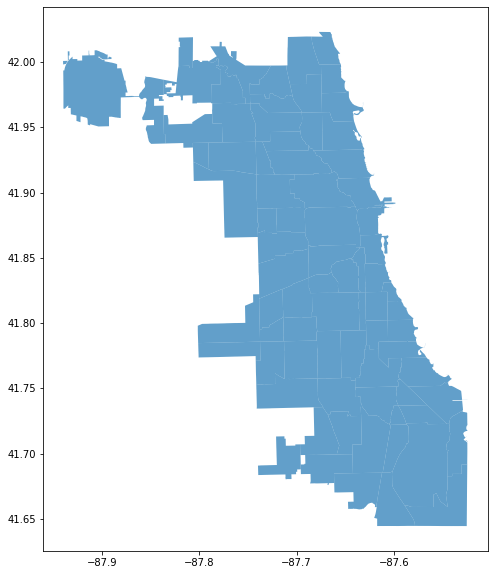

In [75]:
fig, ax = plt.subplots(figsize = (10,10))
chicago_map.plot(ax = ax, alpha=0.7)

# 🌎 Creating a GeoDataFrame and plotting

### Grouped start and end station using whole dataset

In [76]:
grouped_stations.head(5)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
1934132,"(-87.6, 41.79)","(-87.6, 41.79)",21355,4.308348,3.250,0.000000,0.000000
1891187,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",10686,42.056553,32.675,0.000000,0.000000
1857812,"(-87.616743, 41.880958)","(-87.616743, 41.880958)",6283,37.174689,29.650,0.000000,0.000000
1959680,"(-87.59, 41.8)","(-87.59, 41.8)",6262,11.578390,3.880,0.000000,0.000000
1935142,"(-87.6, 41.79)","(-87.59, 41.8)",5908,8.314897,7.070,1.386964,1.386964


In [77]:
# Creating geometry using a column with tuple lng, lat
g1 = [Point(x) for x in grouped_stations['start_lng_lat']]

In [78]:
# Create GeoDataFrame
grouped_geo_df = gpd.GeoDataFrame(grouped_stations, crs="EPSG:4326", geometry=g1)

In [259]:
# Adjusting tick interval and markersize do dataframe
size1 = grouped_geo_df['count'].to_numpy()
s1 = [s*0.1 for s in size1]

range = grouped_geo_df.head(100)['count'].max() - grouped_geo_df.head(100)['count'].min()
tick_interval = range // 10

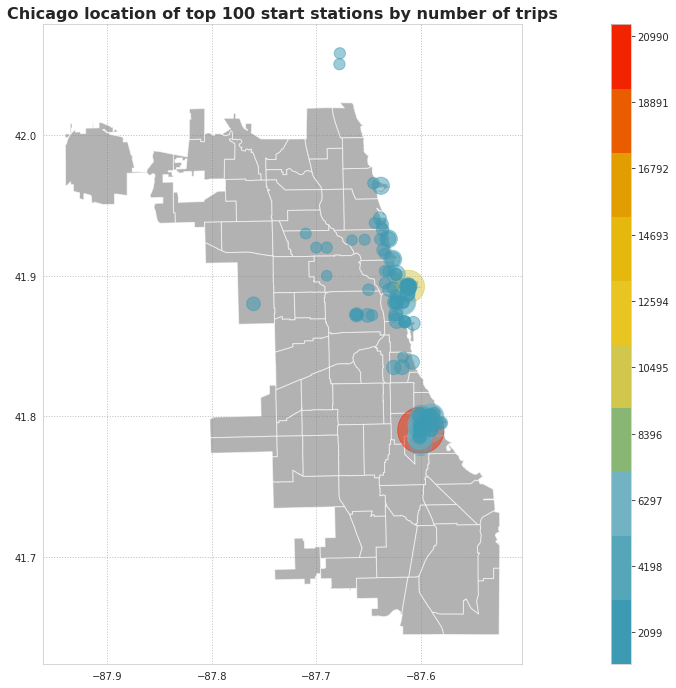

In [262]:
with sns.axes_style('whitegrid'):
  fig, ax = plt.subplots(figsize = (12,12))
  plt.title('Top 100 start stations by number of trips location on Chicago', loc="center", fontsize=16, fontweight="bold")
  plt.tick_params(axis='both', grid_color='grey', grid_linewidth=1, grid_linestyle=':', grid_alpha=0.5)
 
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="3%", pad=0.1)
  
  chicago_map.plot(ax = ax, alpha=0.6, color="grey")
  grouped_geo_df.head(100).plot(ax=ax, column='count', markersize=s1, marker="o", alpha=0.5, cmap=cmap, legend=True, cax=cax)
  #cax.set_ylabel('Number of trips by start station', rotation=90, fontsize=14)
  cax.tick_params(labelsize='10')

  loc = plticker.MultipleLocator(base=tick_interval) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc)


### Grouped start and end station using sampled dataset

In [91]:
grouped_big_sample.head()

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median
52731,"(-87.6, 41.79)","(-87.6, 41.79)",354,3.977881,3.275,0.000000,0.000000
52533,"(-87.6010727606, 41.78509714636)","(-87.599861, 41.791478)",110,4.269364,3.910,0.716597,0.716597
51736,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",109,41.010183,28.930,0.000000,0.000000
53375,"(-87.59, 41.8)","(-87.59, 41.8)",108,13.667407,4.880,0.000000,0.000000
52927,"(-87.599861, 41.791478)","(-87.6010727606, 41.78509714636)",100,5.133600,3.980,0.716597,0.716597


In [92]:
# Creating geometry using a column with tuple lng, lat
gs = [Point(x) for x in grouped_big_sample['start_lng_lat']]

In [93]:
# Create GeoDataFrame
grouped_geo_df_sample = gpd.GeoDataFrame(grouped_big_sample, crs="EPSG:4326", geometry=gs)

In [94]:
grouped_geo_df_sample = grouped_geo_df_sample.sort_values(by='count', ascending=True)

In [214]:
range = grouped_geo_df_sample['count'].max() - grouped_geo_df_sample['count'].min()
tick_sample = range // 10

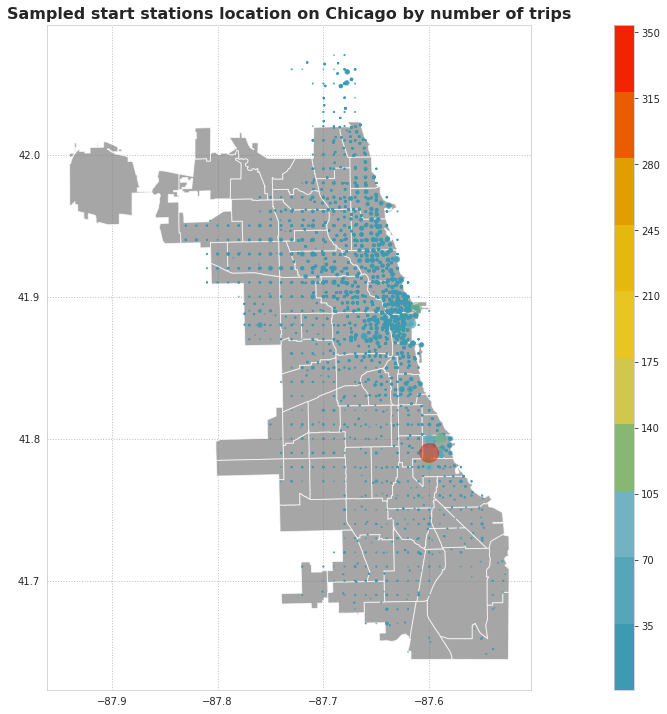

In [263]:
with sns.axes_style('whitegrid'):
  fig, ax = plt.subplots(figsize = (12,14))
  plt.title('Sampled start stations location on Chicago by number of trips', loc="center", fontsize=16, fontweight="bold")
  plt.tick_params(axis='both', grid_color='grey',grid_linewidth=1, grid_linestyle=':', grid_alpha=0.5)

  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="3%", pad=0)

  chicago_map.plot(ax = ax, alpha=0.7, color="grey")
  grouped_geo_df_sample.plot(ax=ax, column="count", markersize='count', marker="o", alpha=0.5, cmap=cmap, legend=True, cax=cax)
  cax.tick_params(labelsize='10') 
  loc = plticker.MultipleLocator(base=tick_sample) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc) 

In [204]:
# Adjusting tick interval and markersize  
sc_list = grouped_geo_df_sample.query('count > 10')['count'].to_numpy()
sc = [s*15 for s in sc_list]

range = grouped_geo_df_sample.query('count > 10')['count'].max() - grouped_geo_df_sample.query('count > 10')['count'].min()
tick_int1 = range // 10

sl_list = grouped_geo_df_sample.query('count > 10')['ride_length_median'].to_numpy()
sl = [s*5 for s in sl_list]

range = grouped_geo_df_sample.query('count > 10')['ride_length_median'].max() - grouped_geo_df_sample.query('count > 10')['ride_length_median'].min()
tick_int2 = range // 10

sd_list = grouped_geo_df_sample.query('count > 10')['distance_median'].to_numpy()
sd = [s*15 for s in sd_list]

range = grouped_geo_df_sample.query('count > 10')['distance_median'].max() - grouped_geo_df_sample.query('count > 10')['distance_median'].min()
tick_int3 = range / 10

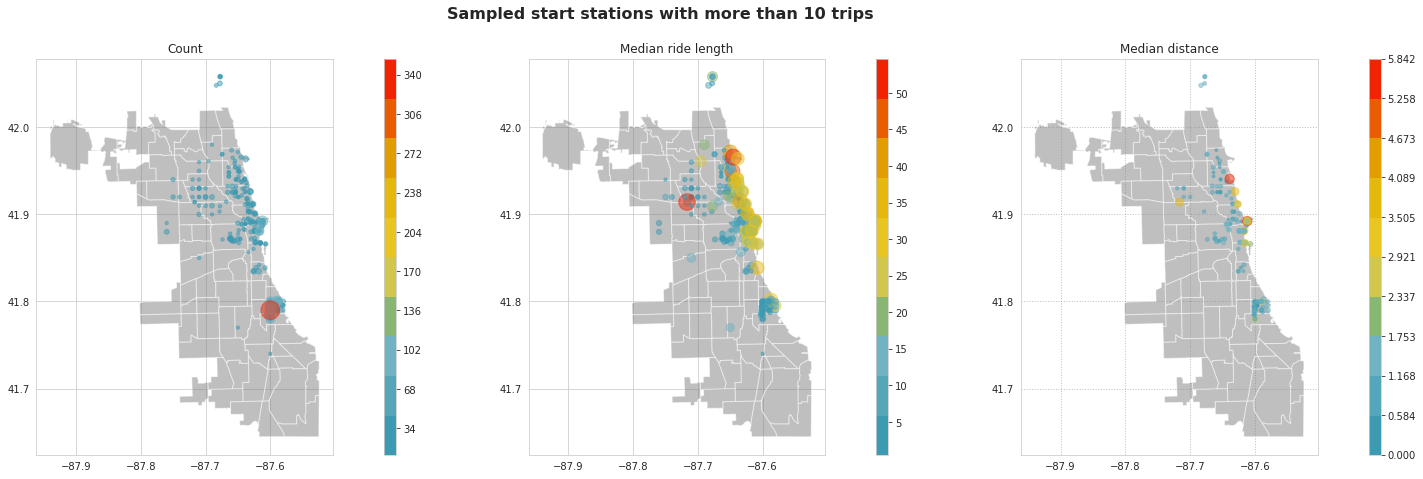

In [205]:

with sns.axes_style('whitegrid'):
  fig, axes = plt.subplots(1, 3, figsize = (25,10))
  fig.suptitle('Sampled start stations with more than 10 trips', fontsize=16, fontweight="bold", y=0.85)
  plt.tick_params(axis='both', grid_color='grey',grid_linewidth=1, grid_linestyle=':', grid_alpha=0.5)

  # Count
  divider = make_axes_locatable(axes[0])
  cax = divider.append_axes("right", size="3%", pad=0)
  

  chicago_map.plot(ax=axes[0], alpha=0.5, color="grey")
  grouped_geo_df_sample.query('count > 10').plot(ax=axes[0], markersize='count', marker="o", alpha=0.5, cmap=cmap, column="count", legend=True, cax=cax)
  axes[0].set_title("Count")
  loc = plticker.MultipleLocator(base=tick_int1) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc)


  # Ride length
  divider = make_axes_locatable(axes[1])
  cax = divider.append_axes("right", size="3%", pad=0)
  

  chicago_map.plot(ax=axes[1], alpha=0.5, color="grey")
  grouped_geo_df_sample.query('count > 10').plot(ax=axes[1], markersize=sl, marker="o", alpha=0.5, cmap=cmap, column='ride_length_median', legend=True, cax=cax)
  axes[1].set_title("Median ride length")
  loc = plticker.MultipleLocator(base=tick_int2) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc)
  

  # Distance
  divider = make_axes_locatable(axes[2])
  cax = divider.append_axes("right", size="3%", pad=0)
  

  chicago_map.plot(ax=axes[2], alpha=0.5, color="grey")
  grouped_geo_df_sample.query('count > 10').plot(ax=axes[2], markersize=sd, marker="o", alpha=0.5, cmap=cmap, column='distance_median', legend=True, cax=cax)
  axes[2].set_title("Median distance")
  loc = plticker.MultipleLocator(base=tick_int3) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc)





### **Grouped Members** from whole dataset

In [180]:
grouped_member_station.head(5)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median,geometry
1103204,"(-87.6, 41.79)","(-87.6, 41.79)",19460,4.100821,3.20,0.000000,0.000000,POINT (-87.60000 41.79000)
1120495,"(-87.59, 41.8)","(-87.59, 41.8)",5324,11.516414,3.78,0.000000,0.000000,POINT (-87.59000 41.80000)
1096565,"(-87.6010727606, 41.78509714636)","(-87.599861, 41.791478)",5081,4.894432,3.78,0.716597,0.716597,POINT (-87.60107 41.78510)
1096559,"(-87.6010727606, 41.78509714636)","(-87.6014497734, 41.79430062054)",4957,5.503540,4.67,1.023858,1.023858,POINT (-87.60107 41.78510)
1109275,"(-87.599861, 41.791478)","(-87.6010727606, 41.78509714636)",4857,4.819934,3.98,0.716597,0.716597,POINT (-87.59986 41.79148)


In [163]:
# Creating geometry using a column with tuple lng, lat
g2 = [Point(x) for x in grouped_member_station['start_lng_lat']]

In [164]:
# Create GeoDataFrame

geo_df_member = gpd.GeoDataFrame(grouped_member_station, crs="EPSG:4326", geometry=g2)


In [257]:
# Adjusting tick interval and markersize  
size2 = geo_df_member['count'].to_numpy()
s2 = [s*0.1 for s in size2]

range = geo_df_member.head(1000)['count'].max() - geo_df_member.head(1000)['count'].min()
tick_member = range // 10

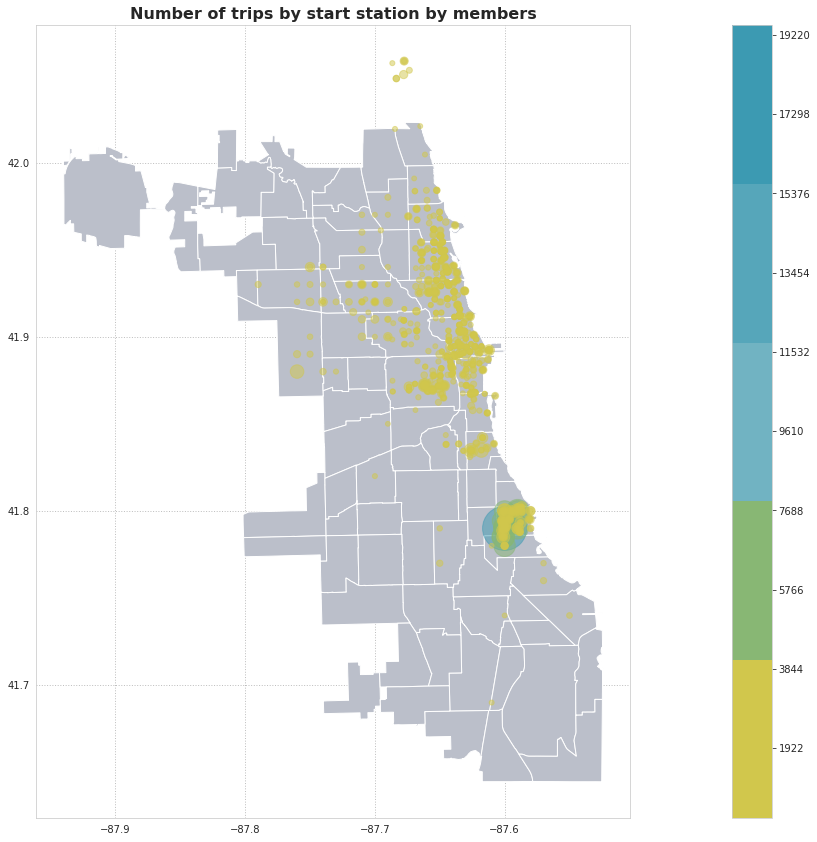

In [258]:
with sns.axes_style('whitegrid'):
  fig, ax = plt.subplots(figsize = (15,15))
  plt.title('Number of trips by start station by members', loc="center", fontsize=16, fontweight="bold")
  plt.tick_params(axis='both', grid_color='grey',grid_linewidth=1, grid_linestyle=':', grid_alpha=0.5)

  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0)


  chicago_map.plot(ax = ax, color="#bbbfca")
  geo_df_member.head(1000).plot(ax=ax, markersize=s2, marker="o", alpha=0.5, cmap=cmap_members, column='count', legend=True, cax=cax)
  loc = plticker.MultipleLocator(base=tick_member) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc)


### **Grouped Casual Users** from whole dataset

In [212]:
grouped_casual_station.head(5)

,start_lng_lat,end_lng_lat,count,ride_length_mean,ride_length_median,distance_mean,distance_median,geometry
916500,"(-87.612043, 41.892278)","(-87.612043, 41.892278)",9494,44.926034,35.325,0.000000,0.000000,POINT (-87.61204 41.89228)
892359,"(-87.616743, 41.880958)","(-87.616743, 41.880958)",5631,39.168450,30.780,0.000000,0.000000,POINT (-87.61674 41.88096)
892369,"(-87.616743, 41.880958)","(-87.612043, 41.892278)",4761,28.409149,19.970,1.317487,1.317487,POINT (-87.61674 41.88096)
817018,"(-87.62377664, 41.90096039)","(-87.62377664, 41.90096039)",2820,45.351926,40.680,0.000000,0.000000,POINT (-87.62378 41.90096)
916490,"(-87.612043, 41.892278)","(-87.616743, 41.880958)",2588,29.991596,17.475,1.317487,1.317487,POINT (-87.61204 41.89228)


In [194]:
# Creating geometry using a column with tuple lng, lat
gc = [Point(x) for x in grouped_casual_station['start_lng_lat']]


In [195]:
# Create GeoDataFrame

geo_df_casual = gpd.GeoDataFrame(grouped_casual_station, crs="EPSG:4326", geometry=gc)

In [255]:
# Adjusting tick interval and markersize  

sizem = geo_df_casual['count'].to_numpy()
sm = [s*0.1 for s in sizem]

range = geo_df_casual.head(1000)['count'].max() - geo_df_casual.head(1000)['count'].min()
tick_casual = range // 10

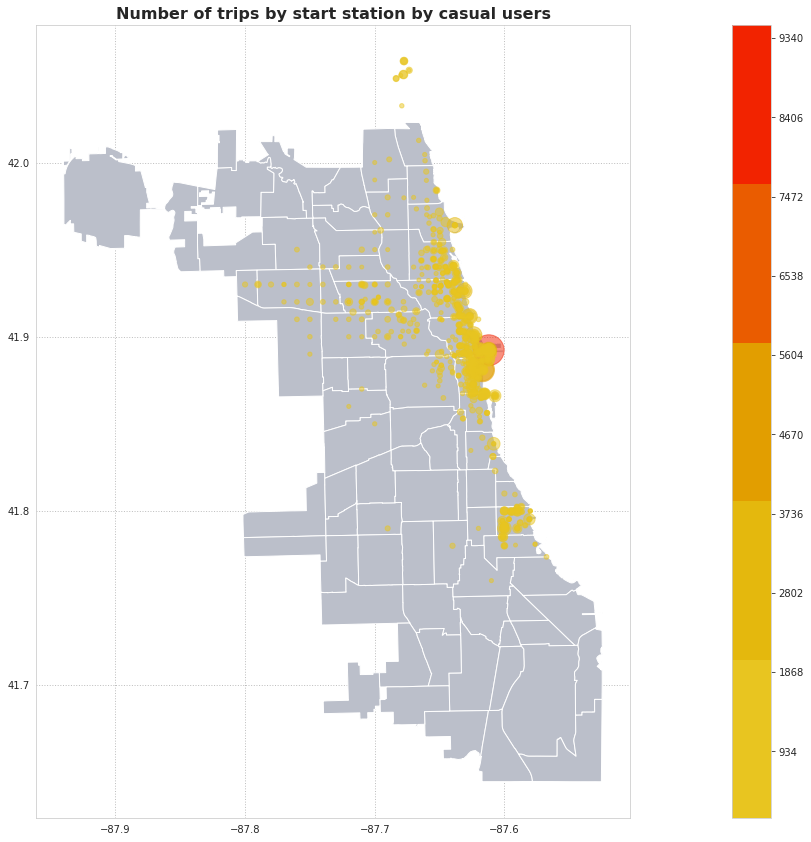

In [256]:
with sns.axes_style('whitegrid'):
  fig, ax = plt.subplots(figsize = (15,15))
  
  plt.title('Number of trips by start station by casual users', loc="center", fontsize=16, fontweight="bold")
  plt.tick_params(axis='both', grid_color='grey',grid_linewidth=1, grid_linestyle=':', grid_alpha=0.5)

  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0)
  
  chicago_map.plot(ax = ax, color="#bbbfca")
  geo_df_casual.head(1000).plot(ax=ax, markersize=sm, marker="o", alpha=0.5, cmap=cmap_casual, column='count', legend=True, cax=cax)
  loc = plticker.MultipleLocator(base=tick_casual) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc)


### Comparision between top stations used by casual users and members

In [253]:
sizem = geo_df_member['count'].to_numpy()
sm50 = [s*0.2 for s in sizem]

range = geo_df_member.head(50)['count'].max() - geo_df_member.head(50)['count'].min()
tick_member_50 = range // 10

sizec = geo_df_casual['count'].to_numpy()
sc50 = [s*0.1 for s in sizec]

range = geo_df_casual.head(50)['count'].max() - geo_df_casual.head(50)['count'].min()
tick_casual_50 = range // 10


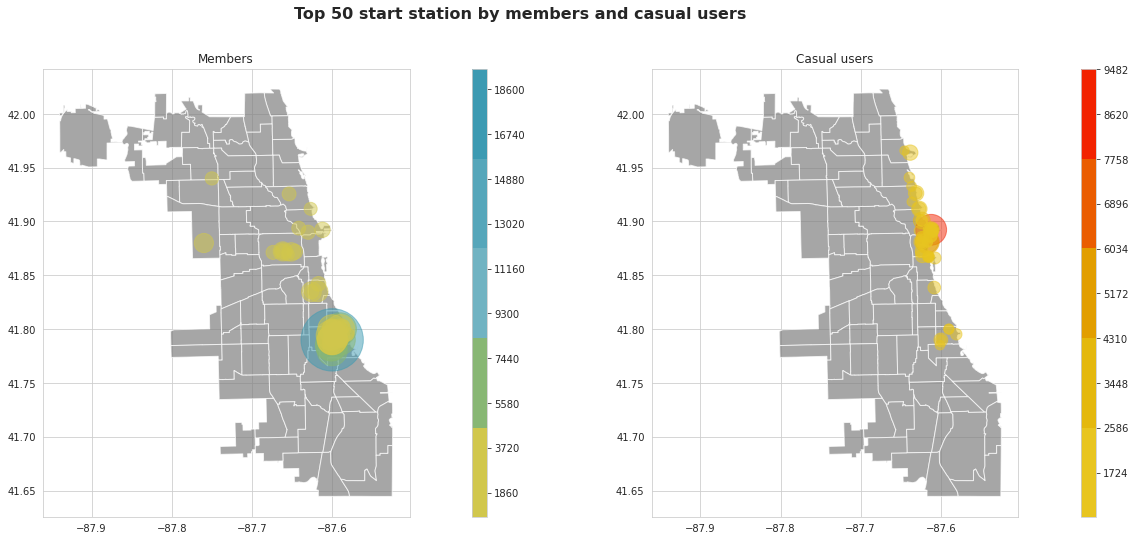

In [254]:
with sns.axes_style('whitegrid'):
  fig, axes = plt.subplots(1, 2, figsize = (20,10))
  fig.suptitle('Top 50 start station by members and casual users', fontsize=16, fontweight="bold", y=0.9)

  divider = make_axes_locatable(axes[0])
  cax = divider.append_axes("right", size="3%", pad=0)

  # Members plot
  chicago_map.plot(ax=axes[0], color="grey", alpha=0.7)
  geo_df_member.head(50).plot(ax=axes[0], markersize=sm50, marker="o", alpha=0.5, cmap=cmap_members, column="count", legend=True, cax=cax)
  axes[0].set_title("Members")

  loc = plticker.MultipleLocator(base=tick_member_50) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc)


  # Casual users plot
  divider = make_axes_locatable(axes[1])
  cax = divider.append_axes("right", size="3%", pad=0)

  chicago_map.plot(ax=axes[1], color="grey", alpha=0.7)
  geo_df_casual.head(50).plot(ax=axes[1], markersize=sc50, marker="o", alpha=0.5, cmap=cmap_casual, column="count", legend=True, cax=cax)
  axes[1].set_title("Casual users")
  loc = plticker.MultipleLocator(base=tick_casual_50) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc)



## Comparision between ride length and distance by casual users and members

In [251]:
sizem = geo_df_member['ride_length_median'].to_numpy()
smrm = [s*5 for s in sizem]

range = geo_df_member.head(1000)['ride_length_median'].max() - geo_df_member.head(1000)['ride_length_median'].min()
tick_member2 = range / 10

sizec = geo_df_casual['ride_length_median'].to_numpy()
scrm = [s*5 for s in sizec]

range = geo_df_casual.head(1000)['ride_length_median'].max() - geo_df_casual.head(1000)['ride_length_median'].min()
tick_casual2 = range / 10


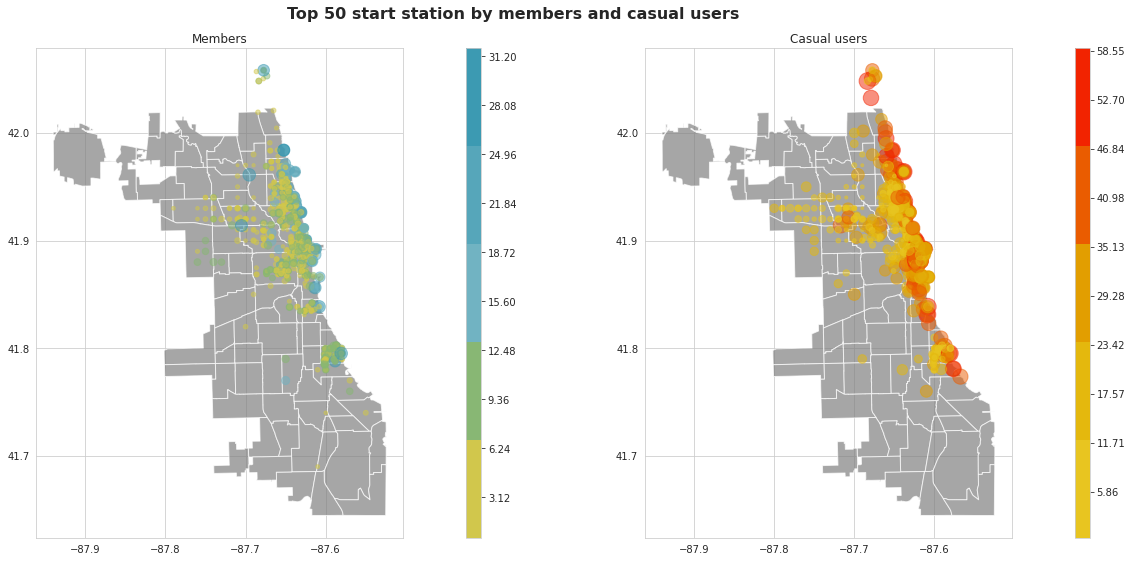

In [252]:
with sns.axes_style('whitegrid'):
  fig, axes = plt.subplots(1, 2, figsize = (20,10))
  fig.suptitle('Median ride length by start station', fontsize=16, fontweight="bold", y=0.9)


  # Members plot

  divider = make_axes_locatable(axes[0])
  cax = divider.append_axes("right", size="3%", pad=0)
  chicago_map.plot(ax=axes[0], color="grey", alpha=0.7)

  geo_df_member.head(1000).plot(ax=axes[0], markersize=smrm, marker="o", alpha=0.5, cmap=cmap_members, column="ride_length_median", legend=True, cax=cax)
  axes[0].set_title("Members")

  loc = plticker.MultipleLocator(base=tick_member2) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc)


  # Casual users plot
  divider = make_axes_locatable(axes[1])
  cax = divider.append_axes("right", size="3%", pad=0)
  chicago_map.plot(ax=axes[1], color="grey", alpha=0.7)

  geo_df_casual.head(1000).plot(ax=axes[1], markersize=scrm, marker="o", alpha=0.5, cmap=cmap_casual, column="ride_length_median", legend=True, cax=cax)
  axes[1].set_title("Casual users")

  loc = plticker.MultipleLocator(base=tick_casual2) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc)



In [264]:
sizem = geo_df_member['distance_median'].to_numpy()
smdm = [s*10 for s in sizem]

range = geo_df_member.head(1000)['distance_median'].max() - geo_df_member.head(1000)['distance_median'].min()
tick_member3 = range / 10

sizec = geo_df_casual['distance_median'].to_numpy()
scdm = [s*10 for s in sizec]

range = geo_df_casual.head(1000)['distance_median'].max() - geo_df_casual.head(1000)['distance_median'].min()
tick_casual3 = range / 10


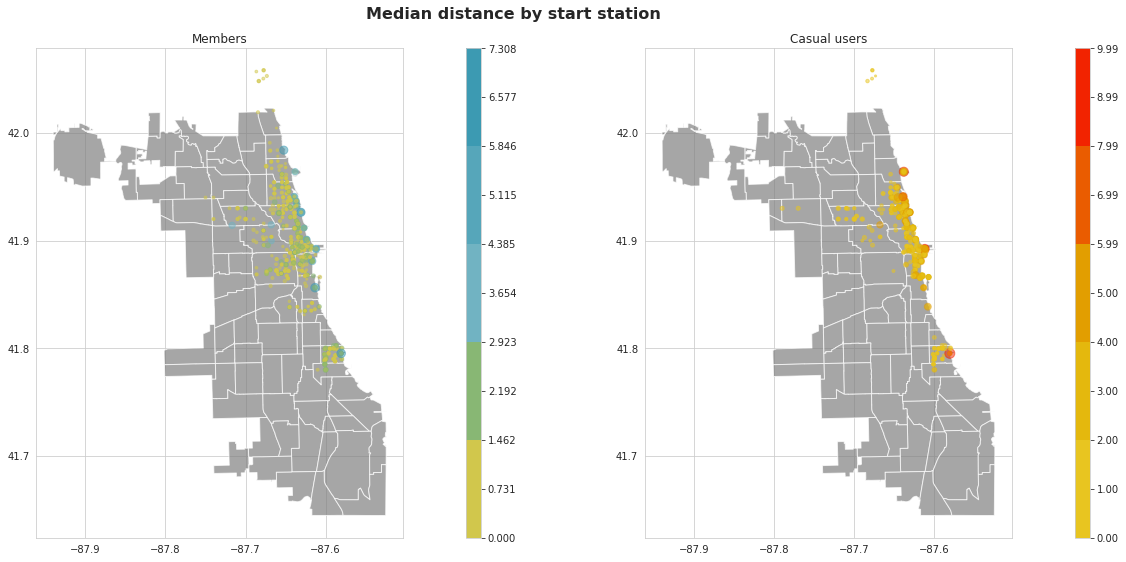

In [265]:
with sns.axes_style('whitegrid'):
  fig, axes = plt.subplots(1, 2, figsize = (20,10))
  fig.suptitle('Median distance by start station', fontsize=16, fontweight="bold", y=0.9)


  # Members plot

  divider = make_axes_locatable(axes[0])
  cax = divider.append_axes("right", size="3%", pad=0)
  chicago_map.plot(ax=axes[0], color="grey", alpha=0.7)

  geo_df_member.head(1000).plot(ax=axes[0], markersize=smdm, marker="o", alpha=0.5, cmap=cmap_members, column="distance_median", legend=True, cax=cax)
  axes[0].set_title("Members")

  loc = plticker.MultipleLocator(base=tick_member3) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc)


  # Casual users plot
  divider = make_axes_locatable(axes[1])
  cax = divider.append_axes("right", size="3%", pad=0)
  chicago_map.plot(ax=axes[1], color="grey", alpha=0.7)

  geo_df_casual.head(1000).plot(ax=axes[1], markersize=scdm, marker="o", alpha=0.5, cmap=cmap_casual, column="distance_median", legend=True, cax=cax)
  axes[1].set_title("Casual users")

  loc = plticker.MultipleLocator(base=tick_casual3) # this locator puts ticks at regular intervals
  cax.yaxis.set_major_locator(loc)



# Recomendations based on new conclusions:

Casual users are highly concentrated on the central and north side of Chicago, while members are more present in the Southside area. This indicates that these regions are priority areas for on-site campaigns targeting casual users.